Notebook purpose

- Understand role of spend distribution for savings behaviour

Does distribution of spends across categories capture anything useful about a person's behviour?

Two dimensions:

- Distribution at a given point in time (Shannon entropy)

- Distribution over time (Jensen-Shannon divergence)


Assumptions:

1. More chaotic life correlates with more chaotic spending correlates with probability of making savings transfer.
2. Entropy scores, based on number of categories spent on, captures chaoticness of spending.

We find that entropy is significantly related to financial behaviour, but that the way in which we calculate entropy matters greatly:
- If we apply Laplace smoothing to counts, entropy is negatively correlated with savings as expected.
- If we don't, it's positively correlated.

We need to understand why that is.

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.aggregators as ag
import entropy.data.cleaners as cl
import entropy.data.make_data as md
import entropy.data.selectors as sl
import entropy.data.validators as vl
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

month = pd.Grouper(key="date", freq="m")
idx_cols = ["user_id", month]

## Data

In [2]:
df = hd.read_txn_data("X77")
dfa = hd.read_analysis_data("X77")
dfs = hd.read_txn_data("777")

Time for read_txn_data                 : 31.92 seconds
Time for read_analysis_data            : 1.21 seconds
Time for read_txn_data                 : 4.00 seconds


In [3]:
# tmp fixes
dfa = dfa.rename(columns={"id": "has_od_fees"})

Defind index of user-months for series subsetting

In [340]:
dfa_user_months = dfa.set_index(["user_id", "date"]).index

Add counts

In [95]:
def counts(df, cat):
    """User-month txn counts by spend catetory."""
    group_cols = idx_cols + [cat]
    return (
        df.loc[df.tag_group.eq("spend") & df.debit]
        .groupby(group_cols, observed=True)
        .size()
        .unstack()
        .fillna(0)
        .rename(columns=lambda x: "count_" + x)
    )


s = counts(df, "tag").reset_index()
dfa = dfa.merge(s, how="left", validate="1:1")

Case study generator

In [106]:
def random_user_counts(df):
    """Return counts for random user.

    Args:
      df: Analysis df with spend tag category counts."""
    user = np.random.choice(df.user_id.unique())
    return df[df.user_id.eq(user)].filter(regex="^count")


random_user_counts(dfa).head(10)

,count_communication,count_services,count_household,count_finance,count_other_spend,count_retail,count_motor,count_travel,count_hobbies
7308,8.0,20.0,46.0,7.0,17.0,10.0,7.0,1.0,2.0
7309,16.0,28.0,63.0,15.0,37.0,22.0,9.0,3.0,4.0
7310,11.0,25.0,82.0,16.0,28.0,12.0,2.0,0.0,2.0
7311,19.0,19.0,106.0,16.0,45.0,12.0,8.0,2.0,8.0
7312,8.0,16.0,94.0,14.0,37.0,8.0,8.0,0.0,4.0
7313,20.0,48.0,96.0,18.0,35.0,36.0,10.0,0.0,8.0
7314,16.0,24.0,90.0,16.0,33.0,20.0,10.0,2.0,2.0
7315,12.0,28.0,62.0,16.0,40.0,8.0,16.0,0.0,0.0
7316,14.0,34.0,87.0,16.0,36.0,22.0,10.0,2.0,4.0
7317,13.0,31.0,110.0,16.0,44.0,14.0,2.0,6.0,2.0


## Relationship between smoothed and unsmoothd entropy

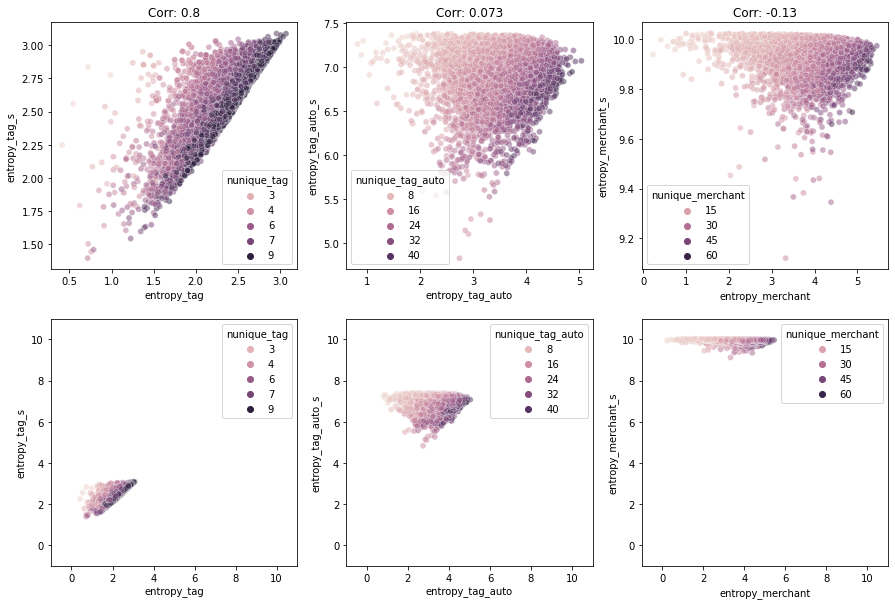

In [402]:
import functools

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, m in enumerate(["tag", "tag_auto", "merchant"]):
    y = f"entropy_{m}_s"
    x = f"entropy_{m}"
    hue = f"nunique_{m}"
    data = dfa
    alpha = 0.5

    scatter = functools.partial(
        sns.scatterplot, x=x, y=y, hue=hue, data=data, alpha=alpha
    )
    scatter(ax=ax[0, i]).set(title=f"Corr: {data[x].corr(data[y]):.2}")
    scatter(ax=ax[1, i]).set(xlim=(-1, 11), ylim=(-1, 11))

For more on relationshiop between the two, see `entropy_calculation.ipynb`. Basically, smoothing turns (user-month spend) distributions with many zero counts from low entropy to high entropy scores. Hence, the more distributions with a large number of zero scores there are, the higher the impact of smoothing, and the lower the relationship between smoothed and unsmoothed scores. The three different categorical variables shown are increasing in their number of unique categories, and hence in the number of possible (and actual) zeroes. As a result, the correlation weakens as we move from left to right.

## Unsmoothed entropy captures the number of distinct categories a user spends money on

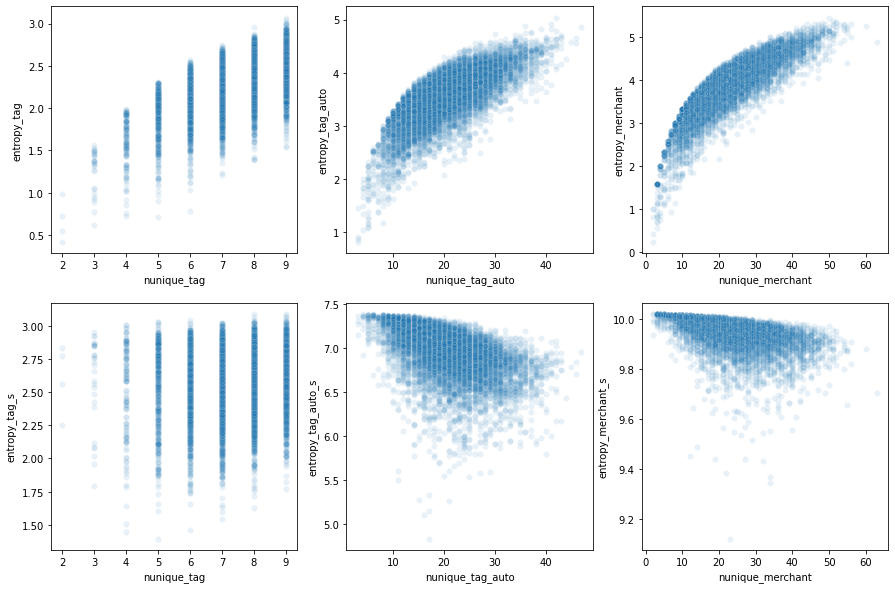

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, m in enumerate(["tag", "tag_auto", "merchant"]):
    sns.scatterplot(
        y=f"entropy_{m}",
        x=f"nunique_{m}",
        data=dfa,
        alpha=0.1,
        ax=ax[0, i],
    )
    sns.scatterplot(
        y=f"entropy_{m}_s",
        x=f"nunique_{m}",
        data=dfa,
        alpha=0.1,
        ax=ax[1, i],
    )

## Smoothed entropy captures the variability in category counts

In [392]:
def calc_ss_diff(df):
    return df.apply(lambda x: (x - x.mean()) ** 2, axis=1).sum(1).rename("ssq_diff")


ss_diff = calc_ss_diff(dfa.filter(regex="^count")).pipe(hd.trim, how="upper").dropna()

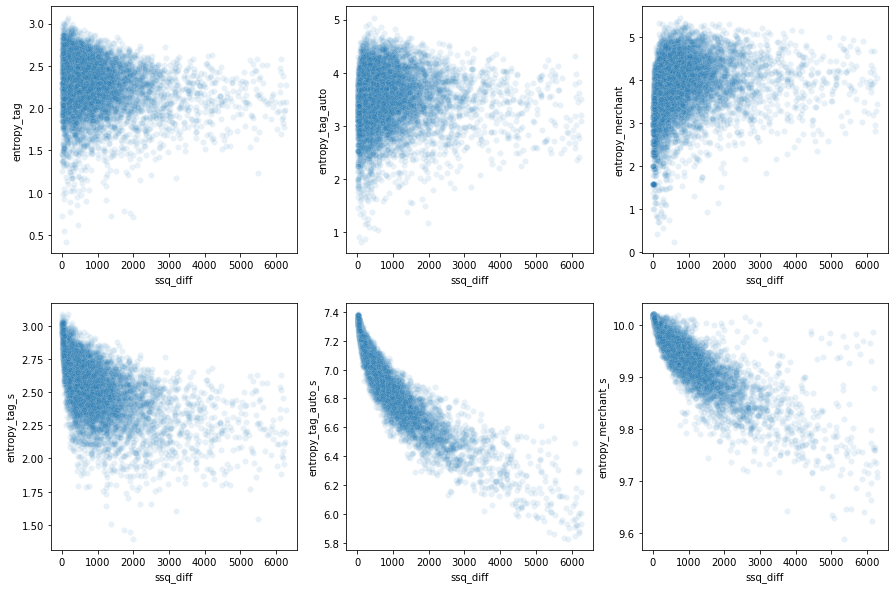

In [391]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, m in enumerate(["tag", "tag_auto", "merchant"]):
    sns.scatterplot(
        y=f"entropy_{m}",
        x=ss_diff,
        data=dfa,
        alpha=0.1,
        ax=ax[0, i],
    )
    sns.scatterplot(
        y=f"entropy_{m}_s",
        x=ss_diff,
        data=dfa,
        alpha=0.1,
        ax=ax[1, i],
    )

## Exploration

### Using k-means clustering

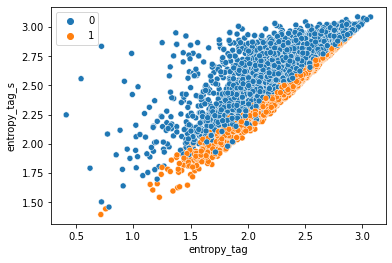

In [301]:
from sklearn.cluster import KMeans

m = KMeans(n_clusters=2, random_state=2312).fit(counts)
cluster = m.labels_

sns.scatterplot(
    x=f"entropy_tag",
    y=f"entropy_tag_s",
    hue=cluster,
    data=dfa,
);

In [284]:
a = dfa[cluster == 0]
b = dfa[cluster == 1]

random_user_counts(b)

,count_communication,count_services,count_household,count_finance,count_other_spend,count_retail,count_motor,count_travel,count_hobbies
7891,2.0,18.0,35.0,23.0,4.0,8.0,0.0,35.0,1.0
7893,3.0,22.0,22.0,19.0,4.0,9.0,0.0,23.0,0.0
7897,1.0,36.0,36.0,4.0,6.0,7.0,0.0,6.0,2.0
7900,4.0,33.0,26.0,2.0,4.0,12.0,1.0,8.0,0.0
7903,3.0,13.0,35.0,2.0,4.0,27.0,0.0,5.0,0.0
7906,3.0,26.0,28.0,5.0,0.0,7.0,0.0,6.0,0.0


### Using PCA

In [204]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

counts = dfa.filter(regex="^count")
pipe = make_pipeline(StandardScaler(), PCA())
new = pipe.fit_transform(counts)

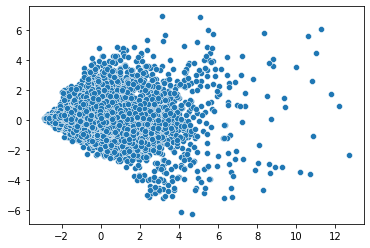

In [232]:
sns.scatterplot(x=new[:, 0], y=new[:, 1]);

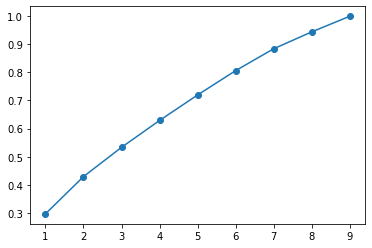

In [233]:
plt.plot(range(1, 10), np.cumsum(pca.explained_variance_ratio_), marker="o");

How do PCs correlate with entropy measures?

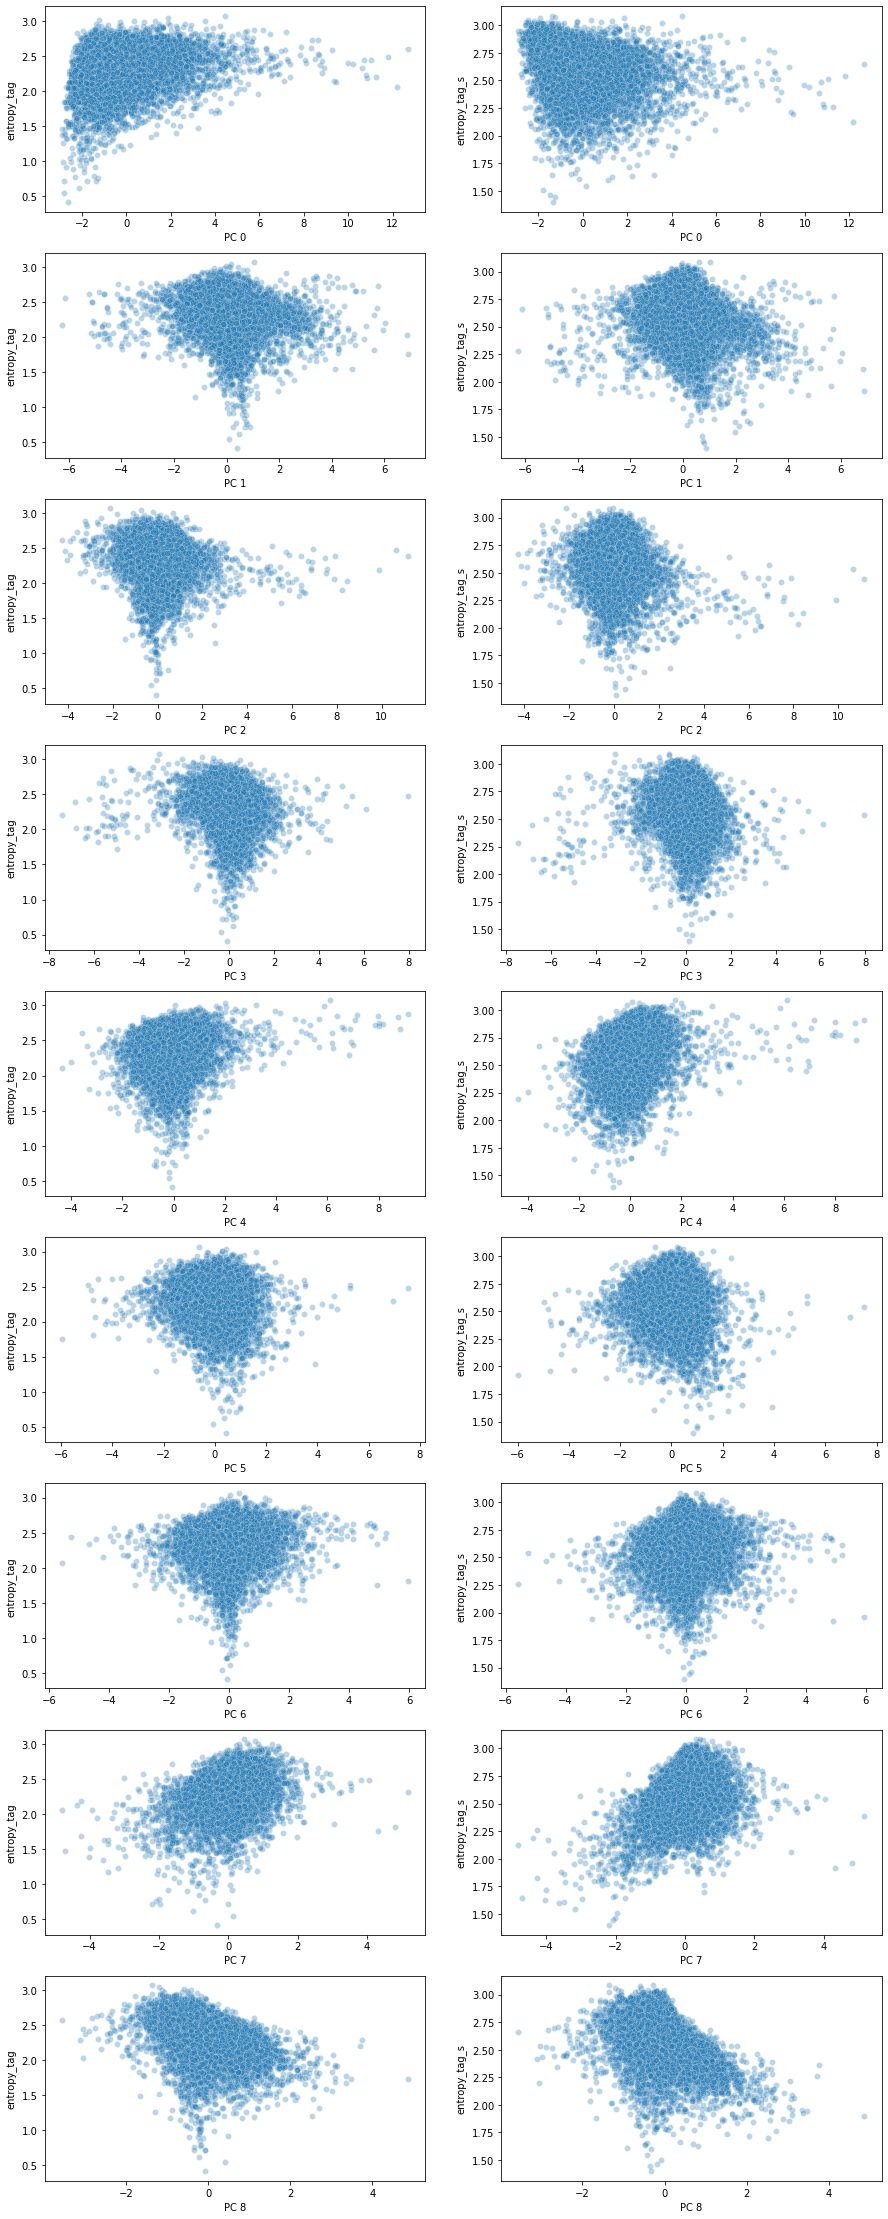

In [234]:
fig, ax = plt.subplots(9, 2, figsize=(15, 40))
row, col = 0, 0
for i in range(9):

    sns.scatterplot(
        y=dfa.entropy_tag,
        x=new[:, i],
        alpha=0.3,
        ax=ax[i, 0],
    )
    sns.scatterplot(
        y=dfa.entropy_tag_s,
        x=new[:, i],
        alpha=0.3,
        ax=ax[i, 1],
    )
    ax[i, 0].set_xlabel(f"PC {i}")
    ax[i, 1].set_xlabel(f"PC {i}")

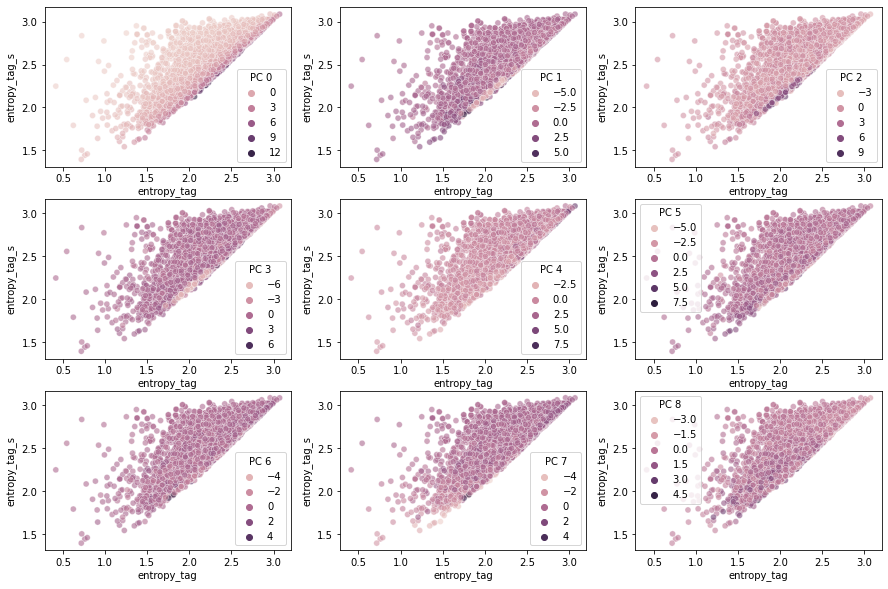

In [235]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
for i in range(9):
    row, col = i // 3, i % 3
    sns.scatterplot(
        x=dfa.entropy_tag,
        y=dfa.entropy_tag_s,
        hue=new[:, i],
        alpha=0.6,
        ax=ax[row, col],
    )
    ax[row, col].legend(title=f"PC {i}")

How do PCs correlate with unique transactions?

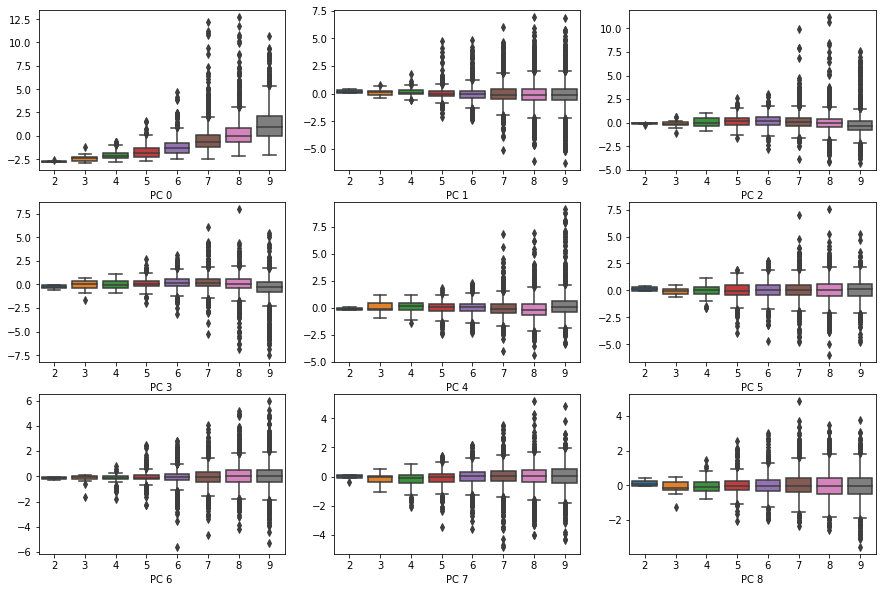

In [236]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
for i in range(9):
    row, col = i // 3, i % 3
    sns.boxplot(
        x=dfa.nunique_tag,
        y=new[:, i],
        ax=ax[row, col],
    )
    ax[row, col].set_xlabel(f"PC {i}")

## Archive

### Effect of number of months observed -- there is none

In [364]:
def calc_num_months(df):
    """Number of months user is observed."""
    return (
        df.groupby(idx_cols)
        .size()
        .groupby("user_id")
        .transform("size")
        .rename("num_months")
    )


num_months = calc_num_months(df).loc[dfa_user_months].values

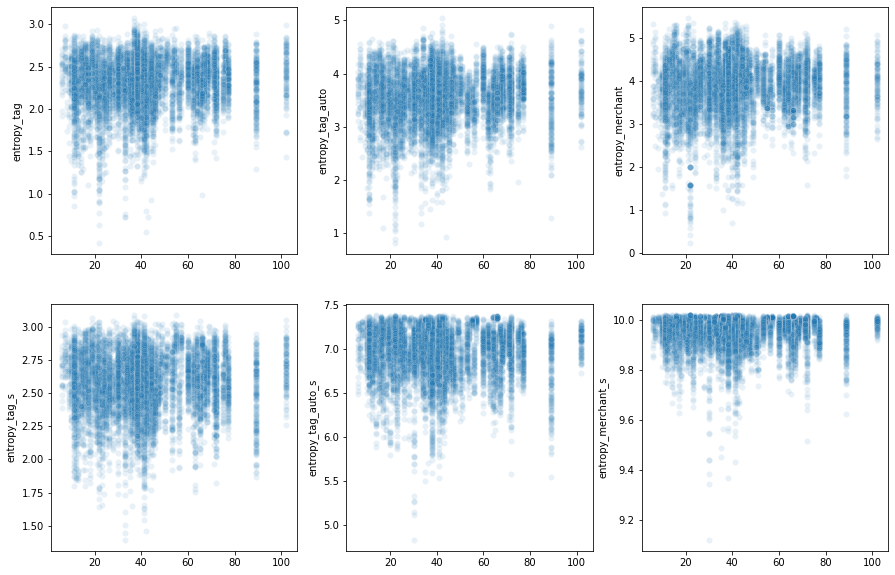

In [365]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, m in enumerate(["tag", "tag_auto", "merchant"]):
    sns.scatterplot(
        y=f"entropy_{m}",
        x=num_months,
        data=dfa,
        alpha=0.1,
        ax=ax[0, i],
    )
    sns.scatterplot(
        y=f"entropy_{m}_s",
        x=num_months,
        data=dfa,
        alpha=0.1,
        ax=ax[1, i],
    )

# old

## Overview

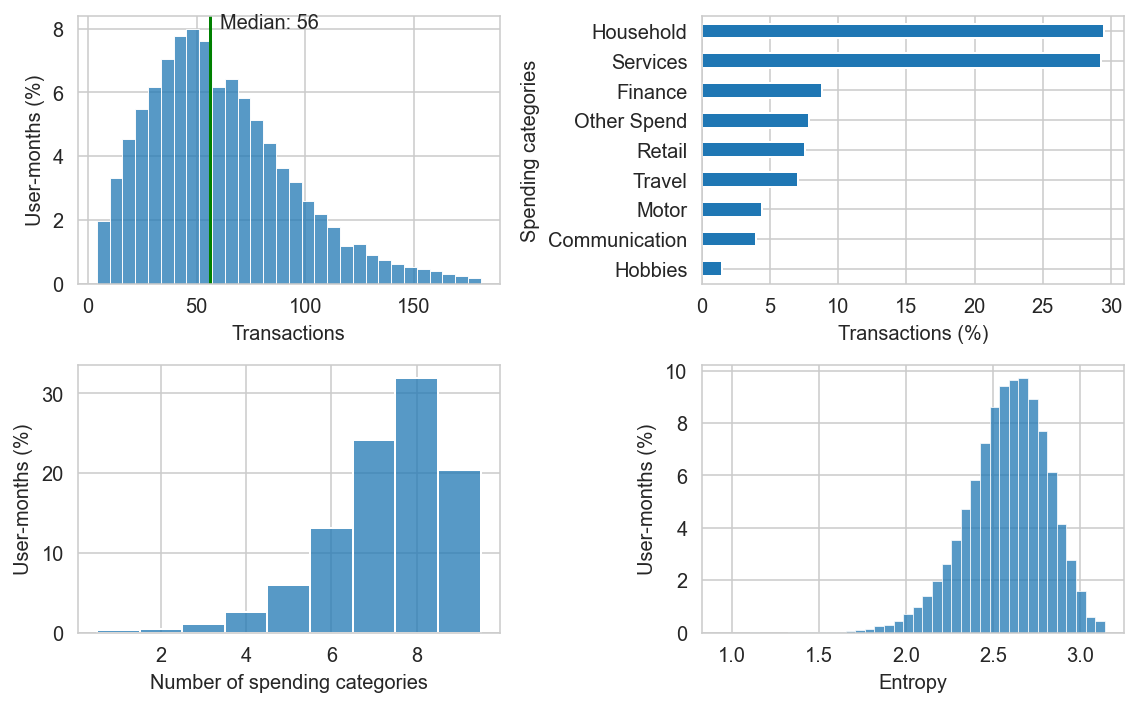

In [7]:
data = df
write = False

figs.txns_breakdowns_and_entropy(data, write=write)

## Case studies

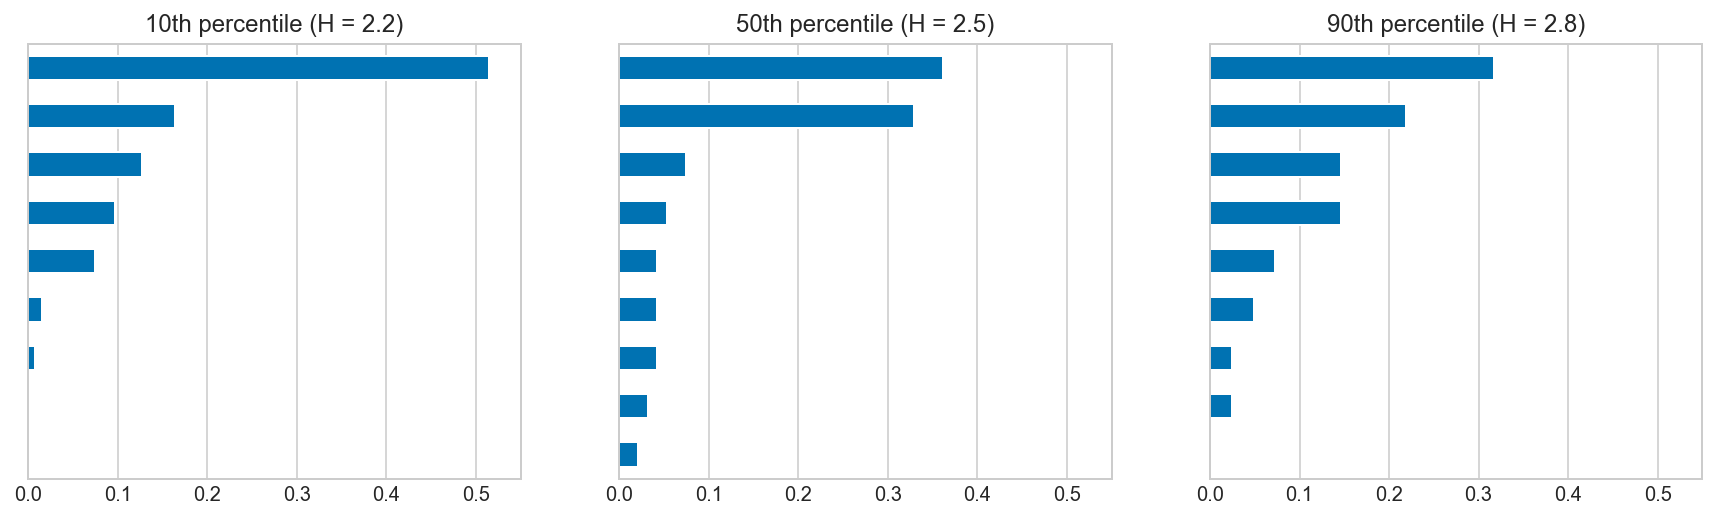

In [12]:
def make_spend_data(df):
    """Retains only spending transactions."""
    df = df[df.tag_group.eq("spend")].copy()
    df["tag"] = df.tag.cat.remove_unused_categories()
    return df


def entropy_pct_case_study(df, pct):
    """Returns first user-month with entropy score at specified percentile."""
    pct_val = np.nanpercentile(df.entropy_sptac, pct)
    pct_data = df[df.entropy_sptac.eq(pct_val)]
    pct_data = pct_data.set_index(["ym", "user_id"])
    first_user_month = pct_data.index.unique()[0]
    return pct_data.loc[first_user_month].reset_index()


def spend_breakdown(df, ax=None):
    """Plots breakdown of spending transactions across tags."""
    spend = df[df.tag_group.eq("spend")].copy()
    spend.tag.value_counts(ascending=True, normalize=True).plot(
        kind="barh", yticks=None, ax=ax
    )


def entropy_pct_case_studies(df, percentiles=None, figsize=(15, 4), **kwargs):
    """Shows spend txns breakdown for entropy percentiles sample users."""
    if percentiles is None:
        percentiles = [10, 50, 90]
    num_plots = len(percentiles)
    spend_data = make_spend_data(df)
    fig, ax = plt.subplots(1, num_plots, figsize=figsize, **kwargs)
    for i, pct in enumerate(percentiles):
        data = entropy_pct_case_study(spend_data, pct)
        entropy = data.entropy_sptac[0]
        title = f"{pct}th percentile (H = {entropy:.1f})"
        spend_breakdown(data, ax=ax[i])
        ax[i].set(title=title)
        ax[i].set_xlim(0, 0.55)
        ax[i].get_yaxis().set_ticks([])
    return fig, ax


entropy_pct_case_studies(df, percentiles=[10, 50, 90]);

We'd expect the cross-sectional distribution for different years to look very similar. The below figure confirms this.

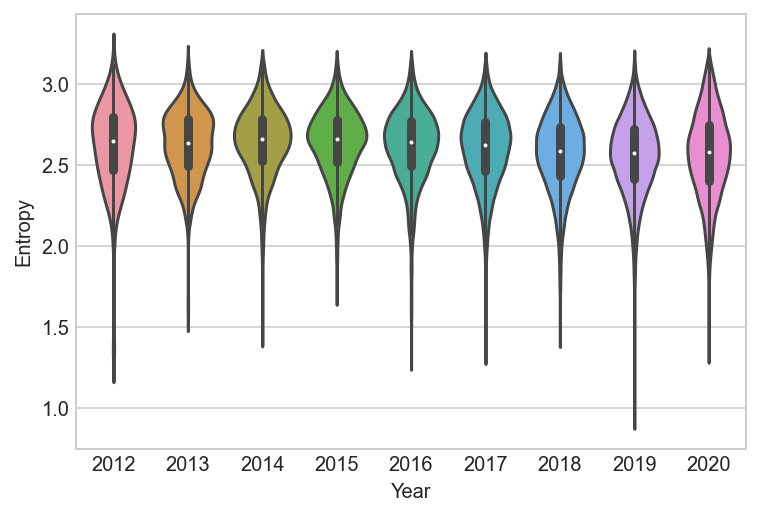

In [9]:
def make_data(df):
    return (
        df.groupby([df.date.dt.year, "user_id", "ym"])
        .entropy_sptac.first()
        .reset_index()
    )


def make_figure(data):
    fig, ax = plt.subplots()
    sns.violinplot(data=data, ax=ax, x="date", y="entropy_sptac")
    ax.set(xlabel="Year", ylabel="Entropy")


data = make_data(df)
make_figure(data)